# Tutorial 3: Inverse Design of a Power Splitter for Silicon Photonics

<p style="text-align: center;">
    <b>Alec Hammond</b>
    <br/>
    July 27, 2022
</p>

In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
import autograd.numpy as npa

from matplotlib import pyplot as plt
import h5py as hp

1.25.0-beta


/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Basic environment setup

In [2]:
seed = 240
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

waveguide_width = 0.5 # (μm)
design_region_width = 2 # (μm)
design_region_height = 1.8 # (μm)
arm_separation = 1.0 # (μm) distance between arms center to center
waveguide_length = 0.5 # (μm)
pml_size = 1.0 # (μm)
delta = 0.02 # size of a pixel (in μm) 20 nm in lumerical exp
# resolution = 20 # (pixels/μm)
resolution = 1/delta # pixels/μm

## Design variable setup

In [3]:
minimum_length = 0.09 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)
eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(4*resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)

Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si)
design_region = mpa.DesignRegion(design_variables,
    volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height)))

## Simulation Setup

In [10]:
Sx = 2*pml_size + 2*waveguide_length + design_region_width # cell size in X
Sy = 2*pml_size + design_region_height + 0.5 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center,
                    eig_parity=mp.ODD_Z+mp.EVEN_Y)]
# source = [mp.Source(mp.ContinuousSource(frequency=0.15),
#                      component=mp.Ez,
#                      center=mp.Vector3(source_center))]


geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)

## Design parameter mapping

In [5]:
def mapping(x,eta,beta):
    # eta in [0,1], skews the distribution towards one material or the other?
    # higher beta makes design more binarized
    
    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    
    # filter
    filtered_field = mpa.conic_filter(x,
        filter_radius,design_region_width,design_region_height,design_region_resolution)
    
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    
    # interpolate to actual materials
    return projected_field.flatten()



In [13]:
index_map = mapping(np.random.rand(Nx, Ny), 0.5, 256)
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)
design_region.update_design_parameters(index_map)


In [14]:
mon_pt = mp.Vector3(*source_center)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt,
                                                            1e-9))

In [24]:
f = sim.get_array(mp.Ex)

In [25]:
f.shape

(250, 215)

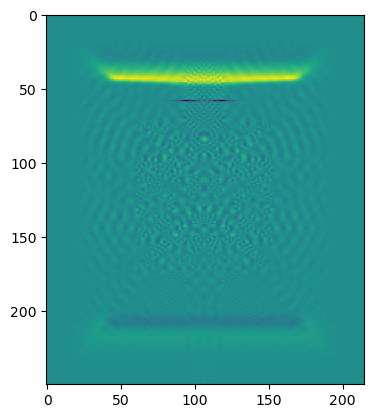

In [27]:
plt.imshow(f)
plt.show()

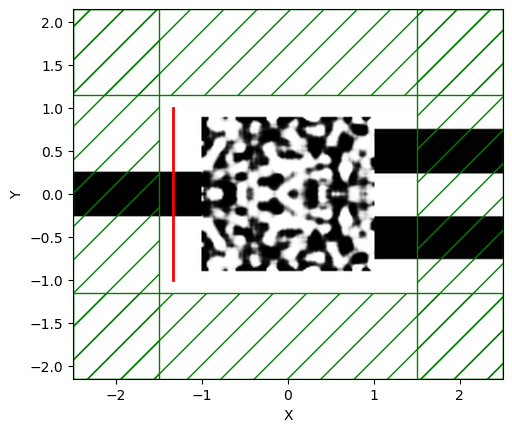

In [28]:
sim.plot2D()
plt.show()